In [1]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.16.1


In [2]:
import os
import numpy as np
import cv2
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.layers import Flatten, Dense, InputLayer, Lambda
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score
import matplotlib.pyplot as plt

In [3]:
# from google.colab import drive
# drive.mount('/content/drive/')


## Data Reading

In [133]:
# Read inputs and images
images = []
labels = []
dataset = 'vehicle_dataset'

for folder in os.listdir(dataset):
    if not folder.startswith('.'):
        label = None

        if folder in ['vehicles']: label = 1
        elif folder in ['non-vehicles']: label = 0

        for file in os.listdir(os.path.join(dataset, folder)):
            if file.endswith('.png'):
                img_path = os.path.join(os.path.join(dataset, folder), file)

                image = cv2.imread(img_path)

                images.append(image)
                labels.append(label)

images = np.array(images, dtype='float32')/255.0
labels = np.array(labels, dtype='int32')

images = images.reshape(-1,64,64,3)

images, labels = shuffle(images, labels, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42) # 0.25 x 0.8 = 0.2


In [134]:
images[0].shape

(64, 64, 3)

## Data Preprocessing

In [138]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,    
        rotation_range=15,    
        width_shift_range=0.1,
        height_shift_range=0.1,  
        horizontal_flip=True,  
        vertical_flip=False)
datagen.fit(X_train)

## Model Defining

In [187]:
# Model definition
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Conv2D(24, (3, 3), padding="same", input_shape=(64, 64, 3)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation("relu"))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(tf.keras.layers.Conv2D(32, (3, 3)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation("relu"))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(tf.keras.layers.Conv2D(48, (3, 3)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation("relu"))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(tf.keras.layers.Conv2D(60, (3, 3)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation("relu"))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
 
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(50, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.summary()

opt = tf.keras.optimizers.Adam(learning_rate=0.0002)

model.compile(loss='binary_crossentropy', optimizer=opt ,metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

/Users/davidtan/Documents/CS171/FinalProject/Vehicle-Detection-Project/venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_140 (Conv2D)             │ (None, 64, 64, 24)     │           672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_66          │ (None, 64, 64, 24)     │            96 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_66 (Activation)      │ (None, 64, 64, 24)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_136               │ (None, 32, 32, 24)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_141 (Conv2D)             │ (None, 30, 30, 32)     │         6,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_67          │ (None, 30, 30, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_67 (Activation)      │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_137               │ (None, 15, 15, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_142 (Conv2D)             │ (None, 13, 13, 48)     │        13,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_68          │ (None, 13, 13, 48)     │           192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_68 (Activation)      │ (None, 13, 13, 48)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_138               │ (None, 6, 6, 48)       │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_143 (Conv2D)             │ (None, 4, 4, 60)       │        25,980 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_69          │ (None, 4, 4, 60)       │           240 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_69 (Activation)      │ (None, 4, 4, 60)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_139               │ (None, 2, 2, 60)       │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_34 (Flatten)            │ (None, 240)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 240)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_68 (Dense)                │ (None, 50)             │        12,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_69 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 60,225 (235.25 KB)

 Trainable params: 59,897 (233.97 KB)

 Non-trainable params: 328 (1.28 KB)

In [188]:
history = model.fit(datagen.flow(X_train, y_train),
                    epochs=50,
                    batch_size=32,
                    verbose=1,
                    validation_data=(X_val, y_val))

Epoch 1/50
  3/333 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 0.4896 - loss: 0.9238 - precision_34: 0.5327 - recall_34: 0.7968

/Users/davidtan/Documents/CS171/FinalProject/Vehicle-Detection-Project/venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


333/333 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - accuracy: 0.7936 - loss: 0.4205 - precision_34: 0.7844 - recall_34: 0.8158 - val_accuracy: 0.5358 - val_loss: 1.2030 - val_precision_34: 1.0000 - val_recall_34: 0.0844
Epoch 2/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - accuracy: 0.9401 - loss: 0.1569 - precision_34: 0.9470 - recall_34: 0.9314 - val_accuracy: 0.8913 - val_loss: 0.2674 - val_precision_34: 0.8286 - val_recall_34: 0.9906
Epoch 3/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - accuracy: 0.9608 - loss: 0.1011 - precision_34: 0.9659 - recall_34: 0.9536 - val_accuracy: 0.8925 - val_loss: 0.2422 - val_precision_34: 0.8262 - val_recall_34: 0.9978
Epoch 4/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - accuracy: 0.9749 - loss: 0.0744 - precision_34: 0.9758 - recall_34: 0.9729 - val_accuracy: 0.9873 - val_loss: 0.0356 - val_precision_34: 0.9878 - val_recall_34: 0.9872
Epoch 5/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - accuracy: 0.9730 - loss: 0.0675 - precision_34: 0.9764 - re

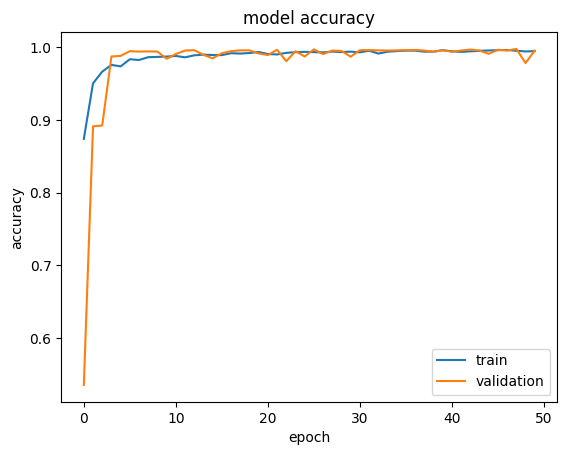

In [189]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc="lower right")
plt.show()

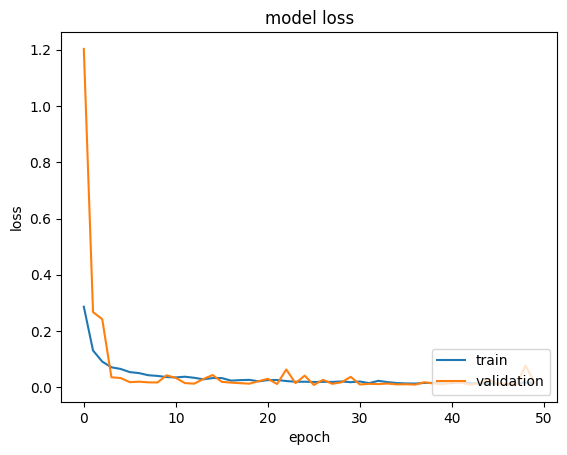

In [190]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc="lower right")
plt.show()

In [11]:
img_path = 'test.jpg'
img = cv2.imread(img_path)
img = cv2.resize(img, (64, 64))  # Resize image to match input size of your model
img_array = img.astype(np.float32) / 255.0  # Normalize pixel values to range [0, 1]
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

predictions = model.predict(img_array)

# Interpret the predictions
if predictions[0][0] > 0.5:
    print("Prediction: Not vehicle")
else:
    print("Prediction: Vehicle")

plt.imshow(cv2.imread(img_path))
plt.axis('off')
plt.show()

[ WARN:0@424.465] global loadsave.cpp:248 findDecoder imread_('test.jpg'): can't open/read file: check file path/integrity


error: OpenCV(4.9.0) /Users/xperience/GHA-OpenCV-Python2/_work/opencv-python/opencv-python/opencv/modules/imgproc/src/resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'resize'


In [191]:

# Test the model
y_pred = model.predict(X_test)

111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


In [193]:
accuracy = accuracy_score(y_test, y_pred>0.5)
roc_auc = roc_auc_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.3f}')
print(f'ROC_AUC: {roc_auc:.3f}')



Accuracy: 0.996
ROC_AUC: 1.000


## Pretrained Models

*VGG16 using ImageNet weights*

In [ ]:
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
  
new_xtrain = preprocess_input(X_train)
new_val = preprocess_input(X_val)

# Freeze the VGG16 layers
for layer in vgg_base.layers:
    layer.trainable = False

# # Add a classifier on top
vgg_model = Sequential()
vgg_model.add(vgg_base)
vgg_model.add(tf.keras.layers.Flatten())
vgg_model.add(tf.keras.layers.Dropout(0.5))
vgg_model.add(Dense(512, activation='relu'))
vgg_model.add(Dense(1, activation='sigmoid')) 
vgg_model.summary()

vgg_model.compile(loss='binary_crossentropy', optimizer='adam' ,metrics=['accuracy'])

# Train the model

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ ?                      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
history = vgg_model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

Epoch 1/10
333/333 ━━━━━━━━━━━━━━━━━━━━ 98s 294ms/step - accuracy: 0.5072 - loss: 1.7707 - val_accuracy: 0.5160 - val_loss: 0.6205
Epoch 2/10
333/333 ━━━━━━━━━━━━━━━━━━━━ 98s 294ms/step - accuracy: 0.5576 - loss: 0.9167 - val_accuracy: 0.5070 - val_loss: 0.8386
Epoch 3/10
333/333 ━━━━━━━━━━━━━━━━━━━━ 98s 293ms/step - accuracy: 0.5791 - loss: 0.8456 - val_accuracy: 0.6596 - val_loss: 0.6040
Epoch 4/10
333/333 ━━━━━━━━━━━━━━━━━━━━ 97s 292ms/step - accuracy: 0.5822 - loss: 0.7352 - val_accuracy: 0.6106 - val_loss: 0.6613
Epoch 5/10
333/333 ━━━━━━━━━━━━━━━━━━━━ 98s 293ms/step - accuracy: 0.5921 - loss: 0.7317 - val_accuracy: 0.7117 - val_loss: 0.5957
Epoch 6/10
333/333 ━━━━━━━━━━━━━━━━━━━━ 99s 297ms/step - accuracy: 0.6016 - loss: 0.6779 - val_accuracy: 0.6579 - val_loss: 0.6120
Epoch 7/10
333/333 ━━━━━━━━━━━━━━━━━━━━ 98s 293ms/step - accuracy: 0.5972 - loss: 0.6826 - val_accuracy: 0.6337 - val_loss: 0.6288
Epoch 8/10
333/333 ━━━━━━━━━━━━━━━━━━━━ 97s 291ms/step - accuracy: 0.5900 - loss: 0

ValueError: too many values to unpack (expected 2)

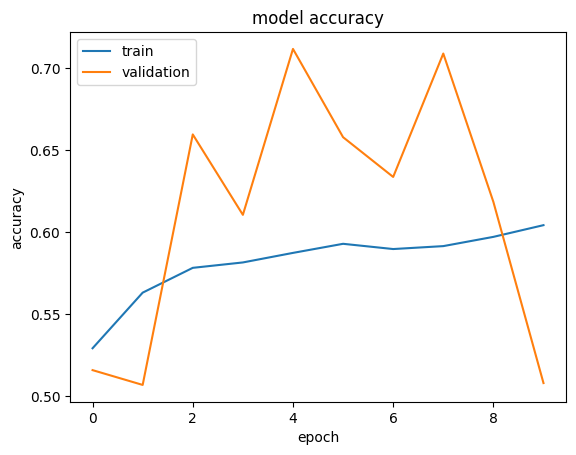

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc="upper left")
plt.show()

In [ ]:
y_pred = vgg_model.predict(X_test)

111/111 ━━━━━━━━━━━━━━━━━━━━ 27s 244ms/step


In [ ]:
accuracy = accuracy_score(y_test, y_pred > 0.5)
print(f'Accuracy: {accuracy:.3f}')

Accuracy: 0.472


*ResNet50*

In [ ]:
baseModel = ResNet50(weights="imagenet", include_top=False, input_shape=[64,64, 3])

pretrained_model = Sequential()
pretrained_model.add(InputLayer(input_shape=(64, 64, 3)))
pretrained_model.add(baseModel)
pretrained_model.add(Flatten())
pretrained_model.add(tf.keras.layers.Dropout(0.5))
pretrained_model.add(tf.keras.layers.Dense(50, activation='relu'))
pretrained_model.add(tf.keras.layers.Dropout(0.5))
pretrained_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
pretrained_model.summary()


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 2, 2, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_21 (Flatten)            │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 50)             │       409,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,997,413 (91.54 MB)

 Trainable params: 23,944,293 (91.34 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
pretrained_pred = pretrained_model.predict(X_test)

111/111 ━━━━━━━━━━━━━━━━━━━━ 12s 98ms/step


In [ ]:
pretrained_pred_binary = (pretrained_pred > 0.5).astype(int)
pretrained_accuracy = accuracy_score(y_test, pretrained_pred_binary)
print(f'Accuracy: {pretrained_accuracy:.3f}')


Accuracy: 0.477
